# Parameter Tuning of MLP Neural Network Using Genetic Algorithms 
## Inteligencia computacional - Trabajo práctico N2
> Grupo 1

Integrantes:
- [Albino, Sebastián](https://github.com/Sebastian-Albino)
- [Pacheco Pilan, Federico](https://github.com/FedericoPacheco)
- [Rodriguez, Alejandro](https://github.com/alerodriguez01)


In [182]:
import pygad.kerasga
import tensorflow
import numpy as np
import matplotlib.pyplot as plt

#### Funciones a utilizar

In [183]:
# Funcion general para el calculo del fitness de cada individuo
def fitness_func(ga_instance, solution, sol_idx, x_arr, y_true_arr, model):
    
    # Transformar el cromosoma de arreglo 1D (cromosoma) a matriz y asignar al modelo de keras
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model = model, weights_vector = solution)
    model.set_weights(weights = model_weights_matrix)

    # Predecir con keras y calcular el error
    y_predic_arr = model.predict(x_arr)
    error_class = tensorflow.keras.losses.MeanAbsoluteError()
    solution_fitness = 1.0 / (error_class(y_true_arr, y_predic_arr).numpy() + 0.00000001)

    return solution_fitness

In [184]:
# Imprimir status de la busqueda
def callback_generation(ga_instance):
    print("Generacion = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

---

### Hermite polynomial
![polinomio-hermite](images/hermite.png)

In [185]:
# Crear configuracion del paper: 1-15-1, con tansig-tansig-reglin
def create_keras_model():
    
    # Paper
    # input_layer  = tensorflow.keras.layers.Dense(1, activation="tanh", input_shape=(1,))
    # dense_layer = tensorflow.keras.layers.Dense(15, activation="tanh")
    # output_layer = tensorflow.keras.layers.Dense(1, activation="linear")
    
    input_layer  = tensorflow.keras.layers.Input(1)
    dense_layer = tensorflow.keras.layers.Dense(15, activation="tanh")
    output_layer = tensorflow.keras.layers.Dense(1, activation="tanh")

    model = tensorflow.keras.Sequential()
    model.add(input_layer)
    model.add(dense_layer)
    model.add(output_layer)

    print("Cantidad de parametros del modelo: ", model.count_params())
    
    return model

In [186]:
# Generar datos de entrenamiento y prueba, evaluando el polinomio en distintos valores de x
def generate_data():
    h_vect = lambda x: 1.1 * (1 - x - 2 * x**2) * np.exp(- x**2 / 2)
    x_train_arr = np.linspace(0, 10, 100)
    x_test_arr = np.linspace(0, 15, 100)
    
    # Normalizar entre 0 y 1
    y_train_arr = (h_vect(x_train_arr) - h_vect(x_train_arr).min()) / (h_vect(x_train_arr).max() - h_vect(x_train_arr).min())
    y_test_arr = (h_vect(x_test_arr) - h_vect(x_test_arr).min()) / (h_vect(x_test_arr).max() - h_vect(x_test_arr).min())

    return x_train_arr, y_train_arr, x_test_arr, y_test_arr

In [187]:
# Parametros
# Ver: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class

num_solutions = 60 # individuos (segun la ultima diapositiva de teoria entre 50 y 100)

num_generations = 30 # iteraciones (subir taanto el numero no cambia nada) - paper: 100

num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool.

# Tipos:
# sss: steady-state selection, rws: roulette wheel selection, random,
# sus: stochastic universal selection, rank, tournament
parent_selection_type = "sss"

# Tipos: single_point, two_points, uniform, scattered
crossover_type = "single_point"

p_crossover = 0.09 # Como el paper (la ultima diapositiva de teoria indica entre 0.6 y 0.9)

# Tipos: random, swap, inversion, scramble
mutation_type = "random"

p_mutation = 0.01 # (segun la ultima diapositiva de teoria entre 0.001 y 0.01)

In [188]:
# Configurar busqueda por GA
hermite_model = create_keras_model()
x_train_arr, h_train_arr, x_test_arr, h_test_arr = generate_data()
keras_ga = pygad.kerasga.KerasGA(model = hermite_model, num_solutions = num_solutions)

# A nested list holding the model parameters. This list is updated after each generation.
initial_population = keras_ga.population_weights # shape = (num_solutions, parameters) -> un array 1D de todos los parametros para cada individuo (solucion)

Cantidad de parametros del modelo:  46


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


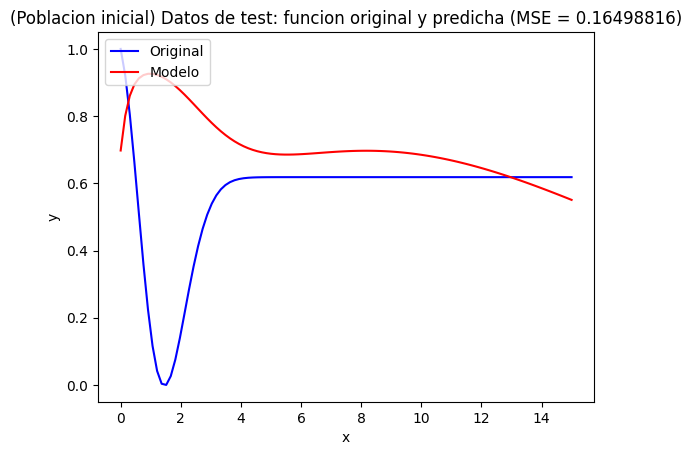

In [189]:
def mostrarPrimeraGeneracion():
    
    best_solution = initial_population[0]
    best_error = 100
    # Buscar el mejor individuo (la mejor solucion) de la poblacion inicial
    for sol in initial_population:
        weights = pygad.kerasga.model_weights_as_matrix(model = hermite_model, weights_vector = sol)
        hermite_model.set_weights(weights = weights)
        # Calcular el error / loss
        error_class = tensorflow.keras.losses.MeanAbsoluteError()
        best_sol_h_predic_arr = hermite_model.predict(x_test_arr)
        error = error_class(h_test_arr, best_sol_h_predic_arr).numpy()
        if(error < best_error):
            best_solution = sol
            best_error = error
            
    # Setear los pesos del mejor individuo de la poblacion inicial en el modelo
    weights = pygad.kerasga.model_weights_as_matrix(model = hermite_model, weights_vector = best_solution)
    hermite_model.set_weights(weights = weights)
    best_sol_h_predic_arr = hermite_model.predict(x_test_arr)
    
    error = "{:.3f}".format(best_error)
    
    # Comparar funcion original y predicha
    plt.title("(Poblacion inicial) Datos de test: funcion original y predicha (MSE = " + str(best_error) + ")")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x_test_arr, h_test_arr, color = "blue", label = "Original")
    plt.plot(x_test_arr, best_sol_h_predic_arr, "red", label = "Modelo")
    plt.legend(loc = "upper left")
    plt.show()

mostrarPrimeraGeneracion()

In [190]:
# Crear instancia de GA
ga_instance = pygad.GA(
    num_generations = num_generations, 
    num_parents_mating = num_parents_mating, 
    initial_population = initial_population,
    fitness_func = lambda ga_instance, solution, sol_idx: fitness_func(ga_instance, solution, sol_idx, x_train_arr, h_train_arr, hermite_model),
    parent_selection_type = parent_selection_type,
    crossover_type = crossover_type,
    crossover_probability = p_crossover,
    mutation_type = mutation_type,
    mutation_probability = p_mutation,
    on_generation = callback_generation
)

# Realizar busqueda y guardar los resultados
ga_instance.run()
ga_instance.save("./ga_test")

4/4 [==============================] - 0s 2ms/step
Generacion = 1
4/4 [==============================] - 0s 1ms/step
Fitness    = 4.95553863945037
4/4 [==============================] - 0s 1ms/step
Generacion = 2
4/4 [==============================] - 0s 1ms/step
Fitness    = 4.95553863945037
4/4 [==============================] - 0s 882us/step
Generacion = 3
4/4 [==============================] - 0s 1ms/step
Fitness    = 5.904384305282949
4/4 [==============================] - 0s 1ms/step
Generacion = 4
4/4 [==============================] - 0s 1ms/step
Fitness    = 6.7966095410456004
4/4 [==============================] - 0s 1ms/step
Generacion = 5
4/4 [==============================] - 0s 1ms/step
Fitness    = 6.7966095410456004
4/4 [==============================] - 0s 1ms/step
Generacion = 6
4/4 [==============================] - 0s 741us/step
Fitness    = 7.021749303048283
4/4 [==============================] - 0s 1ms/step
Generacion = 7
4/4 [==============================] - 0s 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


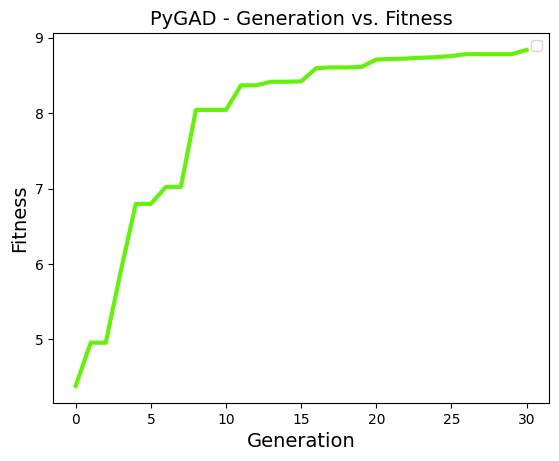

Evolucion de la función de fitness por generacion


In [191]:
# Imprimir evolucion de la func de fitness por generacion
ga_instance.plot_fitness()
print("Evolucion de la función de fitness por generacion")

In [192]:
# Asignar mejores pesos hallados al modelo de keras
best_solution, _, _ = ga_instance.best_solution()
best_weights = pygad.kerasga.model_weights_as_matrix(model = hermite_model, weights_vector = best_solution)
hermite_model.set_weights(weights = best_weights)

4/4 [==============================] - 0s 994us/step


In [193]:
# Calcular el error / loss
error_class = tensorflow.keras.losses.MeanAbsoluteError()
best_sol_h_predic_arr = hermite_model.predict(x_test_arr)
error = error_class(h_test_arr, best_sol_h_predic_arr).numpy()
error = "{:.3f}".format(error)

4/4 [==============================] - 0s 1ms/step


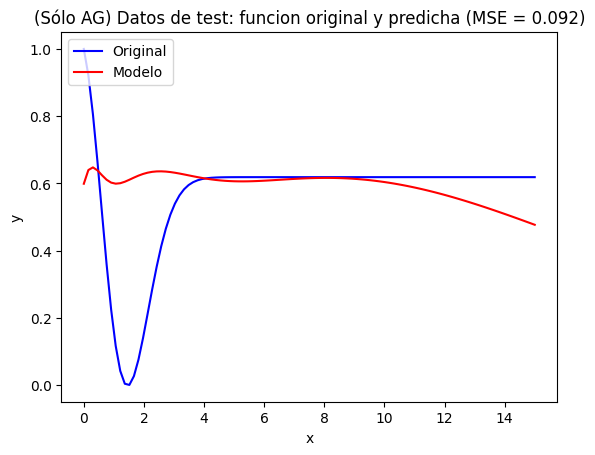

In [194]:
# Comparar funcion original y predicha
plt.title("(Sólo AG) Datos de test: funcion original y predicha (MSE = " + str(error) + ")")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x_test_arr, h_test_arr, color = "blue", label = "Original")
plt.plot(x_test_arr, best_sol_h_predic_arr, "red", label = "Modelo")
plt.legend(loc = "upper left")
plt.show()

In [195]:
# Terminar de entrenar modelo con keras
hermite_model.compile(loss = "mae", optimizer = "adam", metrics = ["mae"])
# Ya tiene los pesos del AG
history = hermite_model.fit(
    x_train_arr, 
    h_train_arr, 
    epochs = 200, 
    validation_data= (x_test_arr, h_test_arr), 
    verbose = 2
)

Epoch 1/200
4/4 - 1s - loss: 0.1129 - mae: 0.1129 - val_loss: 0.0978 - val_mae: 0.0978 - 507ms/epoch - 127ms/step
Epoch 2/200
4/4 - 0s - loss: 0.1097 - mae: 0.1097 - val_loss: 0.0915 - val_mae: 0.0915 - 29ms/epoch - 7ms/step
Epoch 3/200
4/4 - 0s - loss: 0.1065 - mae: 0.1065 - val_loss: 0.0909 - val_mae: 0.0909 - 27ms/epoch - 7ms/step
Epoch 4/200
4/4 - 0s - loss: 0.1044 - mae: 0.1044 - val_loss: 0.0903 - val_mae: 0.0903 - 27ms/epoch - 7ms/step
Epoch 5/200
4/4 - 0s - loss: 0.1027 - mae: 0.1027 - val_loss: 0.0856 - val_mae: 0.0856 - 28ms/epoch - 7ms/step
Epoch 6/200
4/4 - 0s - loss: 0.1008 - mae: 0.1008 - val_loss: 0.0834 - val_mae: 0.0834 - 28ms/epoch - 7ms/step
Epoch 7/200
4/4 - 0s - loss: 0.0999 - mae: 0.0999 - val_loss: 0.0842 - val_mae: 0.0842 - 29ms/epoch - 7ms/step
Epoch 8/200
4/4 - 0s - loss: 0.0972 - mae: 0.0972 - val_loss: 0.0848 - val_mae: 0.0848 - 27ms/epoch - 7ms/step
Epoch 9/200
4/4 - 0s - loss: 0.0955 - mae: 0.0955 - val_loss: 0.0825 - val_mae: 0.0825 - 29ms/epoch - 7ms/ste

In [200]:
# Calcular el error / loss
# error_class = tensorflow.keras.losses.MeanSquaredError()
best_sol_h_predic_arr = hermite_model.predict(x_test_arr)
# error = error_class(h_test_arr, best_sol_h_predic_arr).numpy()

# Dado que calcula mal el error (no se por que), lo calculo con evaluate
results = hermite_model.evaluate(x_test_arr, h_test_arr)
error = "{:.3f}".format(results[0])

4/4 [==============================] - 0s 3ms/step - loss: 0.0576 - mae: 0.0576


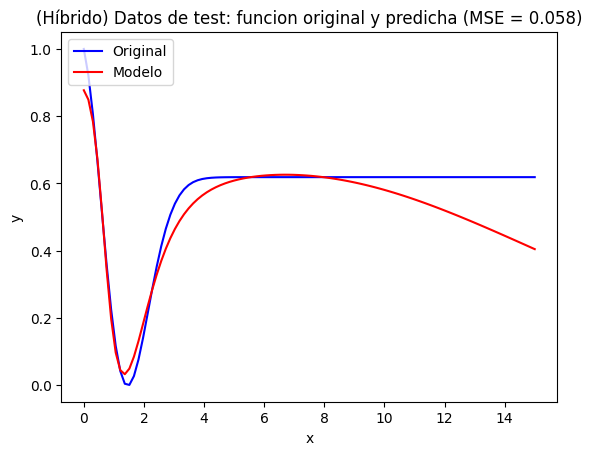

In [201]:
# Comparar funcion original y predicha
plt.title("(Híbrido) Datos de test: funcion original y predicha (MSE = " + str(error) + ")")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x_test_arr, h_test_arr, color = "blue", label = "Original")
plt.plot(x_test_arr, best_sol_h_predic_arr, "red", label = "Modelo")
plt.legend(loc = "upper left")
plt.show()

---

### Nonlinear Dynamic System Identification 
![sistema-no-linear](images/nolinear.png)